# Implementation testing
### Comparison of our optimized model,<br>our regular model, model which uses PCA from sklearn and LBPH model

In [1]:
import numpy as np

from time import time

from sklearn.model_selection import train_test_split
from eigenfaces_model_optimised import EigenfacesModel as EigenfacesModelOptimized
from eigenfaces_model import EigenfacesModel
from eigenfaces_model_other import EigenfacesModel as EigenfacesModelOther

In [2]:
FACES_PATH, FACES_TARGET_PATH = "pics/archive(1)/olivetti_faces.npy", "pics/archive(1)/olivetti_faces_target.npy"

faces = np.load(FACES_PATH)

faces_target = np.load(FACES_TARGET_PATH)


X = faces

y = faces_target

target_names = np.array(list({str(target) for target in y}))
n_classes = target_names.shape[0]

Split into a training set and a test and keep 20% of the data for testing.



In [3]:
def split_data(faces, faces_target, test_percentage, non_trained_person_count = 0):
    faces_dict = {}
    for i, img in zip(faces_target, faces):
        faces_dict[i] = faces_dict.get(i, []) + [img]
    

    faces_train = []
    faces_train_target = []
    faces_test = []
    faces_test_target = []

    labels_faces = list(faces_dict.items())
    for i in range(non_trained_person_count):
        faces_test.extend(labels_faces[i][1])
        faces_test_target.extend([-1] * len(labels_faces[i][1]))
        del faces_dict[i]
    print(faces_dict.keys())

    for person_id, person_faces in faces_dict.items():
        TEST_FACES_COUNT = int(len(person_faces) * test_percentage)
        TRAIN_FACES_COUNT = len(person_faces) - TEST_FACES_COUNT
        faces_test.extend(person_faces[:TEST_FACES_COUNT])
        faces_test_target.extend([person_id] * TEST_FACES_COUNT)
        faces_train.extend(person_faces[TEST_FACES_COUNT:])
        faces_train_target.extend([person_id] * TRAIN_FACES_COUNT)

    return np.array(faces_train), np.array(faces_train_target), np.array(faces_test), np.array(faces_test_target)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=43
)



### Model using scipy PCA implementation

In [5]:
time_started = time()
model2 = EigenfacesModelOther()
model2.train(X_train, y_train, 0.95)
time_taken_scipy = round(time() - time_started, 2)
testing_metrics_scipy = model2.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_scipy))

accuracy: 0.91, precision: 0.97, recall: 0.94, f1: 0.95


### Model which uses optimization for faster computation

In [6]:
time_started = time()
model_optimized = EigenfacesModelOptimized()

model_optimized.train(X_train, y_train, 0.95)
time_taken_optimized = round(time() - time_started, 2)
testing_metrics_optimized = model_optimized.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_optimized))

accuracy: 0.81, precision: 0.89, recall: 0.9, f1: 0.9


### Our non-optimized model

In [7]:
time_started = time()
model = EigenfacesModel()

model.train(X_train, y_train, 0.95)
time_taken_regular = round(time() - time_started, 2)
testing_metrics_regular = model.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_regular))

accuracy: 0.81, precision: 0.98, recall: 0.83, f1: 0.9


### LBPH

In [8]:
from cv2.face import LBPHFaceRecognizer_create

time_started = time()
recognizer = LBPHFaceRecognizer_create()

recognizer.train(X_train, y_train)
time_taken_lbph = round(time() - time_started, 2)

In [9]:
def test(recognizer, faces_test, face_test_labels):
    testing_results = {"False": {"positive": 0, "negative": 0}, "True": {"positive": 0, "negative": 0}}
    min_confidence = float("inf")
    for label, face in zip(face_test_labels, faces_test):
        pred, confidence = recognizer.predict(face)
        pred = (-1 if confidence > 120 else pred)
        min_confidence = min(confidence, min_confidence)
        # print(label, pred, confidence)
        true_prediction = label == pred
        face_in_dataset = pred != -1
        if face_in_dataset:
            testing_results[str(true_prediction)]["positive"] += 1
        else:
            testing_results[str(true_prediction)]["negative"] += 1
    # print(testing_results, min_confidence)
    total_correct = testing_results["True"]["positive"] + testing_results["True"]["negative"]
    total_incorrect = testing_results["False"]["positive"] + testing_results["False"]["negative"]
    accuracy = total_correct / (total_correct + total_incorrect)
    precision = testing_results["True"]["positive"] / (testing_results["True"]["positive"] + testing_results["False"]["positive"])
    recall = testing_results["True"]["positive"] / (testing_results["True"]["positive"] + testing_results["False"]["negative"])
    f1_score = 2 * precision * recall / (precision + recall)
    metrics = accuracy, precision, recall, f1_score
    return [round(metric, 2) for metric in metrics]

In [10]:
testing_metrics_lbph = test(recognizer, X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_lbph))


accuracy: 0.96, precision: 0.96, recall: 1.0, f1: 0.98


### Testing Results

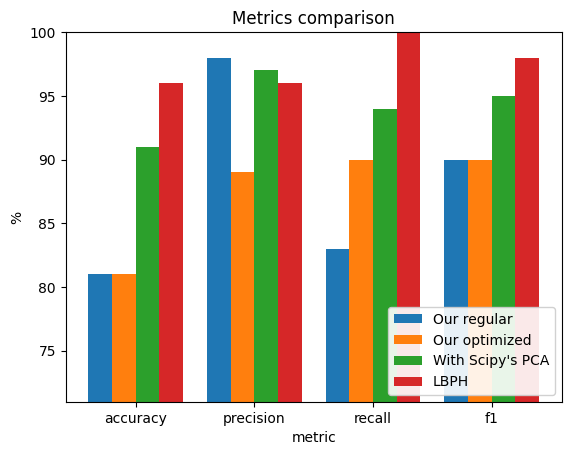

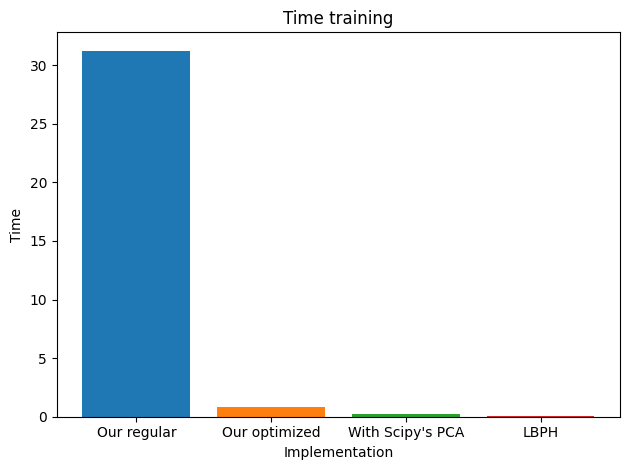

In [11]:
import matplotlib.pyplot as plt
import numpy as np

n = np.array(["accuracy", "precision", "recall", "f1"])

width = 0.35
indices = np.arange(len(n))

algorithm_metrics = [testing_metrics_regular, testing_metrics_optimized, testing_metrics_scipy, testing_metrics_lbph]
algorithm_metrics = [[metric * 100 for metric in metrics] for metrics in algorithm_metrics]
labels = ['Our regular', 'Our optimized',"With Scipy's PCA", 'LBPH']
num_algos = len(algorithm_metrics)
width = 0.8 / num_algos

indices = np.arange(len(n))

for i, metrics in enumerate(algorithm_metrics):
    plt.bar(indices + (i - num_algos/2) * width + width/2, metrics, width=width, label=labels[i])

plt.title("Metrics comparison")

plt.xticks(indices, n)
plt.ylabel('%')
plt.xlabel("metric")
plt.ylim(bottom= max(min(min(metrics) for metrics in algorithm_metrics) - 10, 0), top=100)
# plt.legend()
plt.legend(loc='lower right', framealpha=0.9)
plt.show()
# plt.bar([1, 2, 3], [12, 23, 34], label=["1", "23", "12"])
times = [time_taken_regular, time_taken_optimized, time_taken_scipy, time_taken_lbph]

# labels = ['A', 'B', 'C', 'D']

indices = np.arange(len(times))

for i, time in enumerate(times):
    plt.bar(indices[i], [time])
plt.xticks(indices, labels)

# for i, v in enumerate(times):
#     plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.title("Time training")
plt.xlabel('Implementation')
plt.ylabel('Time')
plt.tight_layout()
plt.show()


## Testing with people not from dataset

In [12]:
X_train, y_train, X_test, y_test = split_data(X, y, 0.2, 10)

dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])


### Model using scipy PCA implementation

In [13]:
model2 = EigenfacesModelOther()
model2.train(X_train, y_train, 0.95)
testing_metrics_scipy = model2.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_scipy))

accuracy: 0.79, precision: 0.63, recall: 0.98, f1: 0.77


### Model which uses optimization for faster computation

In [14]:
model_optimized = EigenfacesModelOptimized()

model_optimized.train(X_train, y_train, 0.95)
testing_metrics_optimized = model_optimized.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_optimized))

accuracy: 0.79, precision: 0.65, recall: 0.89, f1: 0.75


### Our non-optimized model

In [15]:
model = EigenfacesModel()

model.train(X_train, y_train, 0.95)
testing_metrics_regular = model.test(X_test, y_test)
print("accuracy: {}, precision: {}, recall: {}, f1: {}".format(*testing_metrics_regular))

accuracy: 0.89, precision: 0.86, recall: 0.83, f1: 0.84


### Testing results

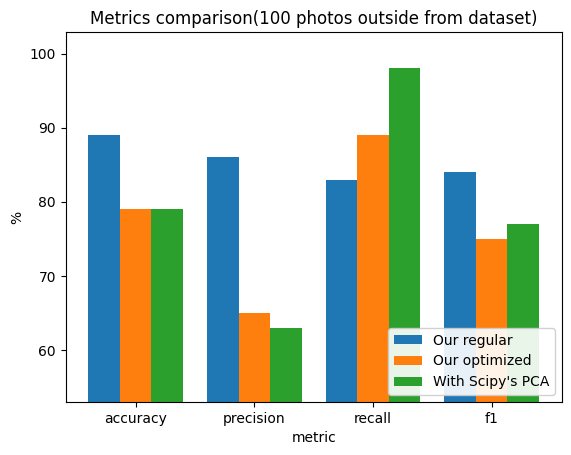

In [16]:
import matplotlib.pyplot as plt
import numpy as np

n = np.array(["accuracy", "precision", "recall", "f1"])

width = 0.35
indices = np.arange(len(n))

algorithm_metrics = [testing_metrics_regular, testing_metrics_optimized, testing_metrics_scipy]
algorithm_metrics = [[metric * 100 for metric in metrics] for metrics in algorithm_metrics]
labels = ['Our regular', 'Our optimized',"With Scipy's PCA"]
num_algos = len(algorithm_metrics)
width = 0.8 / num_algos

indices = np.arange(len(n))

for i, metrics in enumerate(algorithm_metrics):
    plt.bar(indices + (i - num_algos/2) * width + width/2, metrics, width=width, label=labels[i])

plt.title("Metrics comparison(100 photos outside from dataset)")

plt.xticks(indices, n)
plt.ylabel('%')
plt.xlabel("metric")
plt.ylim(bottom= max(min(min(metrics) for metrics in algorithm_metrics) - 10, 0))
# plt.legend()
plt.legend(loc='lower right', framealpha=0.9)
plt.show()
